In [1]:
#
#!pip install whatstk

In [1]:
from whatstk import df_from_whatsapp
import pandas as pd
import re
from whatstk import WhatsAppChat, FigureBuilder
from whatstk.graph import plot
from whatstk.data import whatsapp_urls
chat = WhatsAppChat.from_source(filepath="/Users/leonardrosen/Documents/Projects/nico/data/_chat.txt")
fb = FigureBuilder(chat=chat)

df = df_from_whatsapp("/Users/leonardrosen/Documents/Projects/nico/data/chat_nico_lenny.txt")

In [8]:
df.head()

,date,username,message
0,2021-06-17 18:53:15,Nico Soulmate,Messages and calls are end-to-end encrypted. O...
1,2021-06-17 18:53:15,Nico Soulmate,Ich glaube die Verbindung ist schlecht
2,2021-06-18 19:53:56,Nico Soulmate,Missed voice call
3,2021-06-18 21:46:47,Lenny,image omitted
4,2021-06-18 21:47:01,Lenny,White to win in 2


In [3]:
df.head(2)
df['date'] = pd.to_datetime(df['date'])

In [4]:
total_messages = len(df)
days_active = (df['date'].max() - df['date'].min()).days + 1
avg_per_day = total_messages / days_active

print(f"Total messages: {total_messages}")
print(f"Days active: {days_active}")
print(f"Average messages per day: {avg_per_day:.2f}")

Total messages: 10213
Days active: 1478
Average messages per day: 6.91


In [5]:
messages_per_user = df['username'].value_counts()
print("Messages per user:")
print(messages_per_user)

Messages per user:
username
Nico Soulmate    5841
Lenny            4372
Name: count, dtype: Int64


In [6]:
call_keywords = ["call", "video", "missed"]
call_msgs = df[df['message'].str.lower().str.contains('|'.join(call_keywords))]

In [7]:
call_attempts = call_msgs['username'].value_counts()
print("Call attempts by user:")
print(call_attempts)

Call attempts by user:
username
Nico Soulmate    723
Lenny            424
Name: count, dtype: Int64


In [8]:
import re
from src.utils import classify_call, extract_call_duration, classify_direction, clean_message

In [9]:
call_msgs = call_msgs.copy()

call_msgs.loc[:, 'call_type'] = call_msgs['message'].apply(classify_call)

call_stats = call_msgs.groupby(['username', 'call_type']).size().unstack(fill_value=0)

print("Call stats (user vs. call type):")
print(call_stats)

Call stats (user vs. call type):
call_type      missed  other
username                    
Lenny               0    424
Nico Soulmate     367    356


In [10]:

voice_calls = df[df['message'].str.startswith("Voice call")].copy()
voice_calls['duration_min'] = voice_calls['message'].apply(extract_call_duration)

total_minutes = voice_calls['duration_min'].sum()
total_hours = total_minutes / 60

print(f"Total voice call time: {total_minutes} minutes ({total_hours:.2f} hours)")

Total voice call time: 7532 minutes (125.53 hours)


In [11]:
fig = fb.user_interventions_count_linechart()
plot(fig)

'temp-plot.html'

In [12]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
plot(fig)

'temp-plot.html'

In [13]:
fig = fb.user_interventions_count_linechart(cumulative=True, title='User inteventions count (cumulative)')
plot(fig)

'temp-plot.html'

In [14]:
fig = fb.user_interventions_count_linechart(msg_length=True, cumulative=True, title='Characters sent by user (cumulative)')
plot(fig)

'temp-plot.html'

In [15]:
fig = fb.user_interventions_count_linechart(date_mode='weekday', title='User interventions count (weekly)', xlabel='Week day')
plot(fig)

'temp-plot.html'

Voice Call Stats per Person:
               total_minutes  call_count  total_hours
username                                             
Lenny                   3126         357    52.100000
Nico Soulmate           4406         258    73.433333


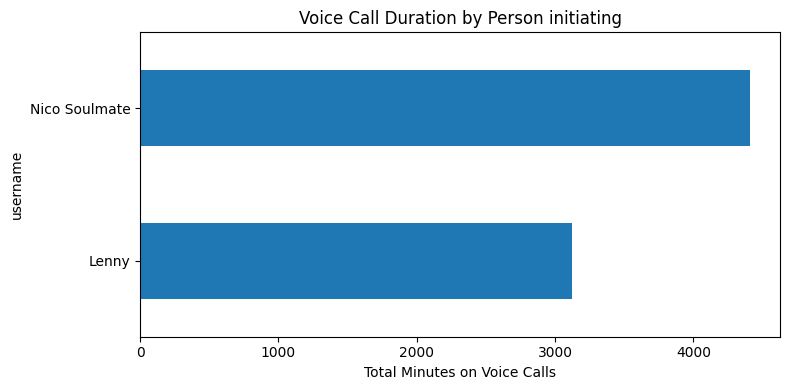

In [16]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# 1. Filter only "Voice call" messages
voice_calls = df[df['message'].str.lower().str.startswith("voice call")].copy()


voice_calls['duration_min'] = voice_calls['message'].apply(extract_call_duration)

# 3. Aggregate by username
call_stats = voice_calls.groupby('username')['duration_min'].agg(['sum', 'count']).rename(
    columns={'sum': 'total_minutes', 'count': 'call_count'}
)

# 4. Add hours for convenience
call_stats['total_hours'] = call_stats['total_minutes'] / 60

print("Voice Call Stats per Person:")
print(call_stats)

# 5. Plot: Total call minutes per person
call_stats['total_minutes'].plot(kind='barh', figsize=(8, 4))
plt.xlabel("Total Minutes on Voice Calls")
plt.title("Voice Call Duration by Person initiating")
plt.tight_layout()
plt.show()

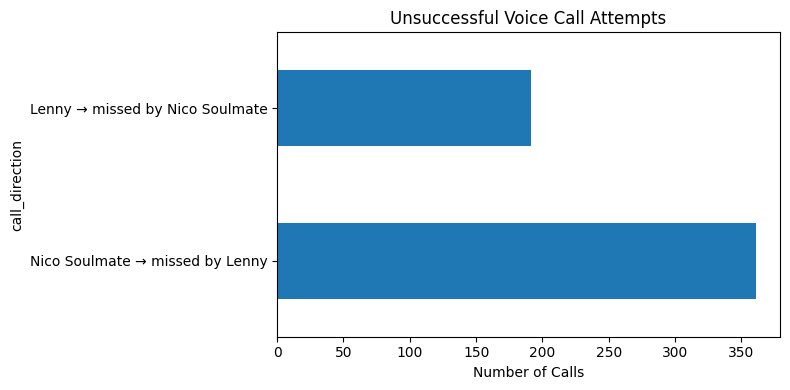

Unsuccessful call attempts:

call_direction
Nico Soulmate → missed by Lenny    361
Lenny → missed by Nico Soulmate    191
Name: count, dtype: int64


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df['date'] = pd.to_datetime(df['date'])
df['clean_msg'] = df['message'].apply(clean_message)

missed_calls_df = df[df['clean_msg'].str.contains("voice call. no answer|missed voice call")].copy()

your_name = "Lenny"
friend_name = "Nico Soulmate"


missed_calls_df['call_direction'] = missed_calls_df.apply(
    lambda row: classify_direction(row, your_name, friend_name), axis=1
)

counts = missed_calls_df['call_direction'].value_counts()

counts = counts[counts.index != "unknown"]

counts.plot(kind='barh', figsize=(8, 4))
plt.title("Unsuccessful Voice Call Attempts")
plt.xlabel("Number of Calls")
plt.tight_layout()
plt.show()

# Print breakdown
print("Unsuccessful call attempts:\n")
print(counts)